# Main Objective

Lorem ipsum.

# Setup environment

In [18]:
%%capture
!pip install --upgrade tensorflow

In [138]:
%%capture --no-display
import os
import glob
import random
from tensorflow import keras
from tensorflow.keras import layers
from keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib import image as img
from tqdm import tqdm

In [20]:
import warnings
warnings.simplefilter('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [21]:
# Impose a seed for reproducibility
random_seed = 421
random.seed(random_seed)

# Dataset

## Dataset description

Lorem ipsum.

## Credits for the dataset

> Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images.

> Bird, J.J. and Lotfi, A. (2024). CIFAKE: Image Classification and Explainable Identification of AI-Generated Synthetic Images.

## Link to download the dataset

[https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

In [22]:
# Set the local path
path_dataset = '/media/guillaume/DATA/COMPUTER_VISION_DATASETS/CIFAKE'

In [23]:
# Derive the train/test and real/fake paths
path_dataset_train = os.path.join(path_dataset, 'train')
path_dataset_train_real = os.path.join(path_dataset_train, 'REAL')
path_dataset_train_fake = os.path.join(path_dataset_train, 'FAKE')
path_dataset_test = os.path.join(path_dataset, 'test')
path_dataset_test_real = os.path.join(path_dataset_test, 'REAL')
path_dataset_test_fake = os.path.join(path_dataset_test, 'FAKE')

In [24]:
# List the samples
samples_list_train_real = list(glob.glob(os.path.join(path_dataset_train_real, '*.jpg')))
samples_list_test_real = glob.glob(os.path.join(path_dataset_test_real, '*.jpg'))
samples_list_train_fake = glob.glob(os.path.join(path_dataset_train_fake, '*.jpg'))
samples_list_test_fake = glob.glob(os.path.join(path_dataset_test_fake, '*.jpg'))

In [25]:
# Count the number of samples and ensure the distribution is balanced
print('Number of samples:')
print('Train split \t Real images: \t {}'.format(len(samples_list_train_real)))
print('Test split \t Real images: \t {}'.format(len(samples_list_test_real)))
print('Train split \t Fake images: \t {}'.format(len(samples_list_train_fake)))
print('Test split \t Fake images: \t {}'.format(len(samples_list_test_fake)))

Number of samples:
Train split 	 Real images: 	 50000
Test split 	 Real images: 	 10000
Train split 	 Fake images: 	 50000
Test split 	 Fake images: 	 10000


In [26]:
# Apply in-place random shuffling
random.shuffle(samples_list_train_real)
random.shuffle(samples_list_test_real)
random.shuffle(samples_list_train_fake)
random.shuffle(samples_list_test_fake)

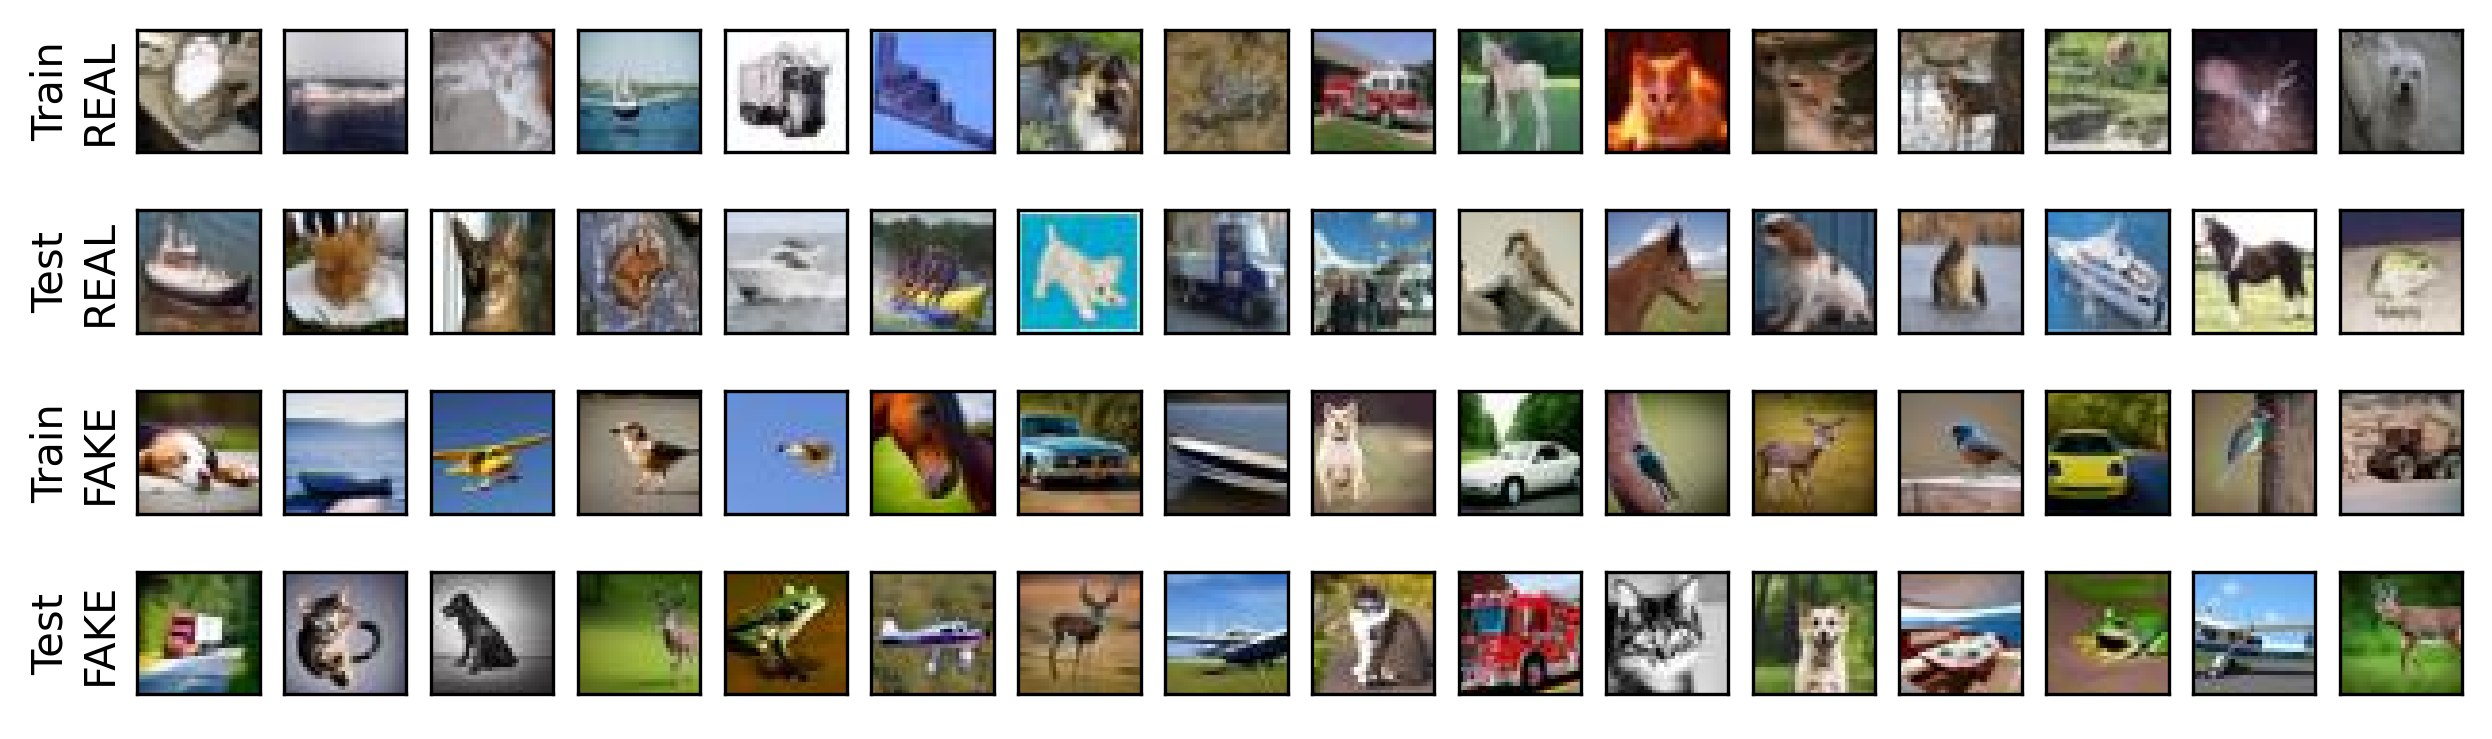

In [27]:
# Display a few images
number_of_displayed_samples = 16

fig, ax = plt.subplots(4, number_of_displayed_samples)
fig.set_dpi(300)
fig.set_size_inches(10, 3, forward=True)

for index in range(number_of_displayed_samples):

    axx = ax[0, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_train_real, samples_list_train_real[index])))
    plt.ylabel('Train\nREAL') if index==0 else None

    axx = ax[1, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_test_real, samples_list_test_real[index])))
    plt.ylabel('Test\nREAL') if index==0 else None

    axx = ax[2, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_train_fake, samples_list_train_fake[index])))
    plt.ylabel('Train\nFAKE') if index==0 else None

    axx = ax[3, index]
    fig.sca(axx)
    plt.imshow(img.imread(os.path.join(path_dataset_test_fake, samples_list_test_fake[index])))
    plt.ylabel('Test\nFAKE') if index==0 else None

[axx.set_xticks([]) for axx in ax.ravel()]
[axx.set_yticks([]) for axx in ax.ravel()]
plt.show()

# Dataloader

In [112]:
image_height, image_width = 32, 32
batch_size = 64
validation_split = 0.2

# Dataloader for the train split
train_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_train,
    shuffle=True,
    seed=random_seed,
    validation_split=1-validation_split,
    subset='training',    
    batch_size=batch_size,
    image_size=(image_height, image_width)
)
print('Classes for the train split: {}'.format(train_set_dataloader.class_names))

# Dataloader for the validation split
validation_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_train,
    shuffle=True,
    seed=random_seed,
    validation_split=validation_split,
    subset='validation',    
    batch_size=batch_size,
    image_size=(image_height, image_width)
)
print('Classes for the validation split: {}'.format(validation_set_dataloader.class_names))

# Dataloader for the test split
test_set_dataloader = tf.keras.utils.image_dataset_from_directory(
    path_dataset_test,
    shuffle=True,
    seed=random_seed,
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(image_height, image_width)
)
print('Classes for the test split: {}'.format(test_set_dataloader.class_names))

Found 100000 files belonging to 2 classes.
Using 20000 files for training.
Classes for the train split: ['FAKE', 'REAL']
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Classes for the validation split: ['FAKE', 'REAL']
Found 20000 files belonging to 2 classes.
Classes for the test split: ['FAKE', 'REAL']


# Helper functions 

In [79]:
def plot_metrics(model_history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs):
    fig, ax = plt.subplots(2, 2)
    fig.set_dpi(300)
    fig.set_size_inches(12, 12, forward=True)

    metric_name = 'loss'
    axx = ax[0, 0]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_loss, color='darkgreen', label='test_{}'.format(metric_name))
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    metric_name = 'recall'
    axx = ax[0, 1]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_recall, color='darkgreen', label='test_{}'.format(metric_name))
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    metric_name = 'accuracy'
    axx = ax[1, 0]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_accuracy, color='darkgreen', label='test_{}'.format(metric_name))    
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    
    metric_name = 'precision'
    axx = ax[1, 1]
    fig.sca(axx)
    plt.plot(model_history.history['{}'.format(metric_name)], label='{}'.format(metric_name))
    plt.plot(model_history.history['val_{}'.format(metric_name)], label='val_{}'.format(metric_name))
    plt.scatter(number_of_epochs -1, test_precision, color='darkgreen', label='test_{}'.format(metric_name))    
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [69]:
def evaluate_model(model, dataloader, split_name):
    loss, accuracy, precision, recall = model.evaluate(dataloader)
    print('Dataset: {}'.format(split_name))
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return loss, accuracy, precision, recall

In [191]:
def plot_confusion_matrix(test_set_dataloader, model):
    
    predicted_values = np.array([])
    predicted_classes = np.array([])
    true_classes = np.array([])
    
    for x, y in test_set_dataloader:        
        predicted_values = np.concatenate([predicted_values, model(x)])
        predicted_classes = np.concatenate([predicted_classes, [0 if pred < 0.5 else 1 for pred in model(x)]])
        true_classes = np.concatenate([true_classes, np.argmax(y, axis=-1)])
    
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap='Blues',fmt='d', square=True, xticklabels=test_set_dataloader.class_names, yticklabels=test_set_dataloader.class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


from sklearn.metrics import roc_curve
from sklearn.metrics import auc


fpr, tpr, thresholds = roc_curve(true_classes, predicted_values)
auc_keras = auc(fpr_keras, tpr_keras)
print(thresholds)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [20000, 313]

# Model 1

In [90]:
model = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal', seed=random_seed),
    layers.Resizing(image_height, image_width),
    layers.Rescaling(scale=1./127.5, offset=-1),    
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='silu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')]
)

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_7 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_11 (Resizing)          │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_11 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,313 (2.00 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Train the model
number_of_epochs = 50

history = model.fit(
    train_set_dataloader,
    validation_data=validation_set_dataloader,
    epochs=number_of_epochs,
    verbose=1)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7432 - loss: 0.4980 - precision: 0.7603 - recall: 0.7033 - val_accuracy: 0.8340 - val_loss: 0.3726 - val_precision: 0.8172 - val_recall: 0.8587
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8600 - loss: 0.3316 - precision: 0.8533 - recall: 0.8669 - val_accuracy: 0.8712 - val_loss: 0.3079 - val_precision: 0.8733 - val_recall: 0.8669
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8970 - loss: 0.2502 - precision: 0.8914 - recall: 0.9021 - val_accuracy: 0.8855 - val_loss: 0.2792 - val_precision: 0.8855 - val_recall: 0.8842
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9104 - loss: 0.2186 - precision: 0.9080 - recall: 0.9112 - val_accuracy: 0.8946 - val_loss: 0.2617 - val_precision: 0.8778 - val_recall: 0.9159
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9243 - loss: 0.1900 - precision: 0.9161 - recall: 0.9330 - val_accuracy: 0.8873 - val_loss: 0.

In [94]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9076 - loss: 0.6157 - precision: 0.9104 - recall: 0.8999
Dataset: Validation
Loss: 0.6140
Accuracy: 0.9082
Precision: 0.9162
Recall: 0.8977
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9099 - loss: 0.5643 - precision: 0.9122 - recall: 0.9053
Dataset: Test
Loss: 0.5667
Accuracy: 0.9082
Precision: 0.9119
Recall: 0.9037


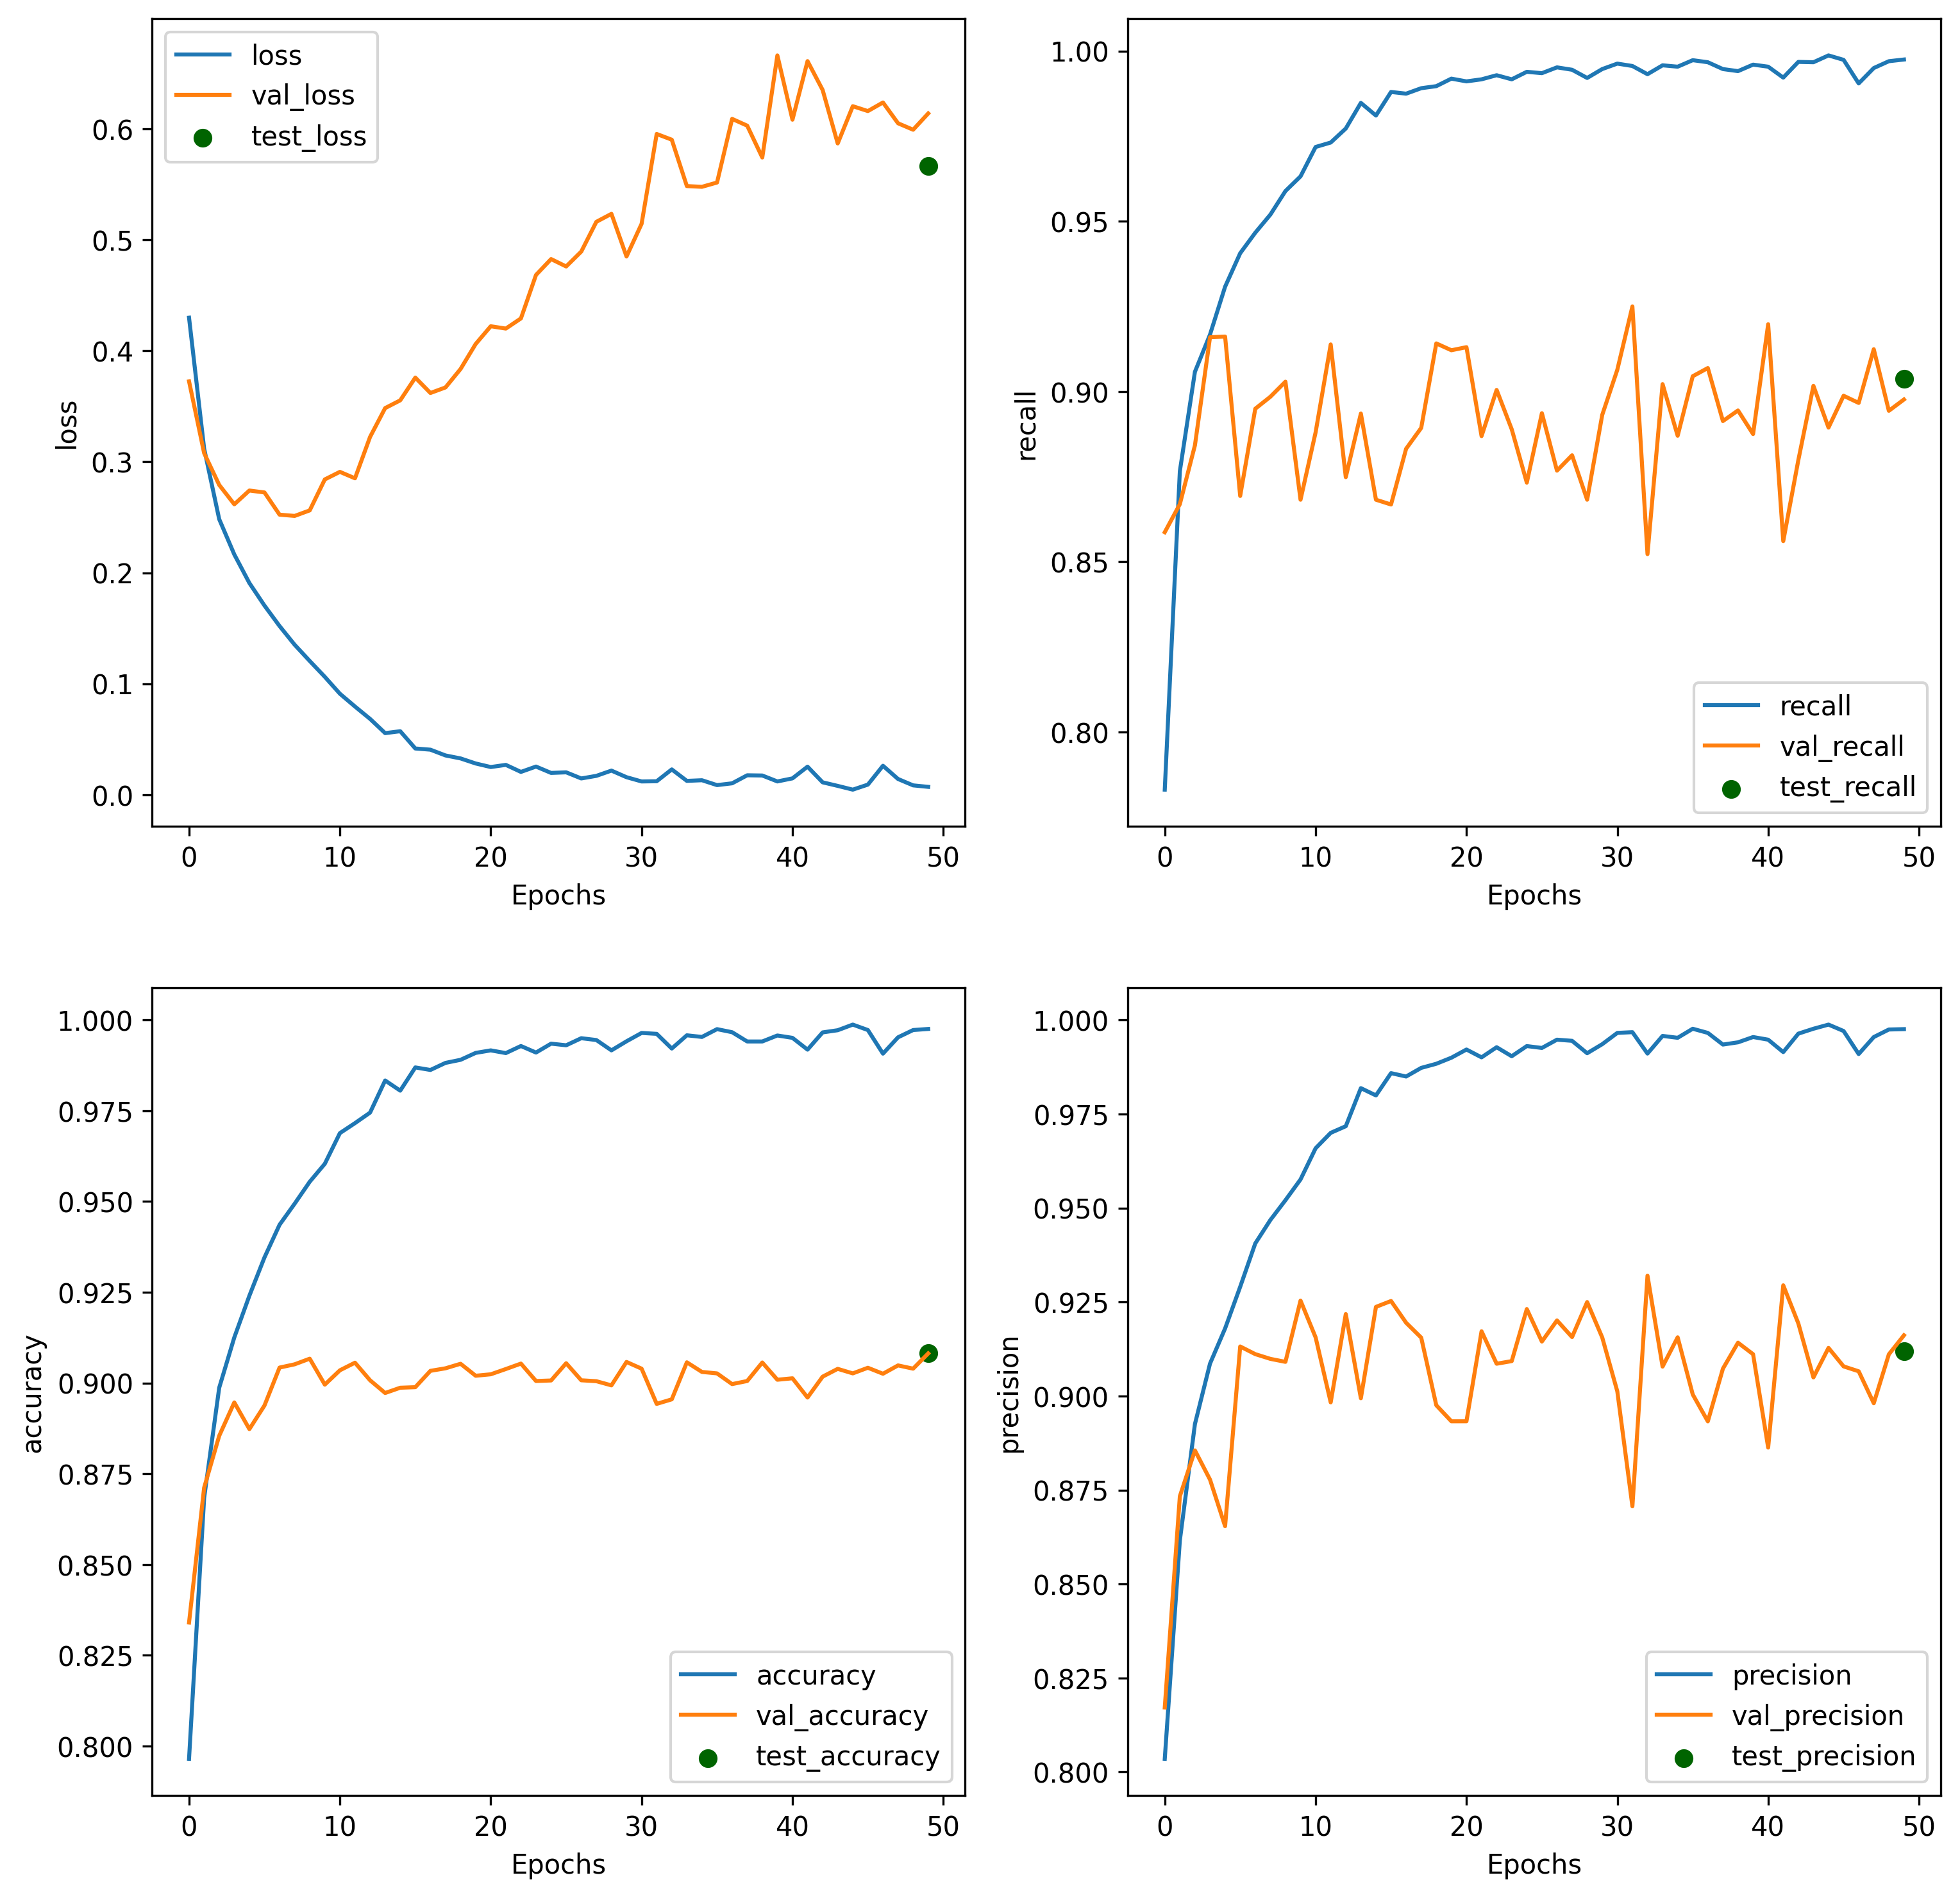

In [95]:
# Display results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)

# Model 2

In [97]:
model = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal', seed=random_seed),
    layers.Resizing(image_height, image_width),
    layers.Rescaling(scale=1./127.5, offset=-1),    
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='silu'),
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(128, activation='silu'),
    tf.keras.layers.Dropout(0.5),    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall')])

# Build the model and show the summary
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_9 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_13 (Resizing)          │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_13 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,409 (2.10 MB)

 Trainable params: 549,409 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# Train the model
number_of_epochs = 50

history = model.fit(
    train_set_dataloader,
    validation_data=validation_set_dataloader,
    epochs=number_of_epochs,
    verbose=1)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6929 - loss: 0.5574 - precision: 0.7027 - recall: 0.6355 - val_accuracy: 0.8755 - val_loss: 0.2956 - val_precision: 0.8576 - val_recall: 0.8993
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8862 - loss: 0.2806 - precision: 0.8845 - recall: 0.8870 - val_accuracy: 0.8853 - val_loss: 0.2743 - val_precision: 0.8424 - val_recall: 0.9468
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9017 - loss: 0.2424 - precision: 0.9036 - recall: 0.8977 - val_accuracy: 0.9125 - val_loss: 0.2215 - val_precision: 0.9336 - val_recall: 0.8872
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9135 - loss: 0.2181 - precision: 0.9176 - recall: 0.9069 - val_accuracy: 0.9180 - val_loss: 0.2079 - val_precision: 0.9133 - val_recall: 0.9230
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9237 - loss: 0.1956 - precision: 0.9286 - recall: 0.9167 - val_accuracy: 0.9130 - val_loss: 0

In [99]:
# Infer the model
evaluate_model(model, validation_set_dataloader, 'Validation')
test_loss, test_accuracy, test_precision, test_recall = evaluate_model(model, test_set_dataloader, 'Test')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9335 - loss: 0.2670 - precision: 0.9338 - recall: 0.9311
Dataset: Validation
Loss: 0.2808
Accuracy: 0.9319
Precision: 0.9343
Recall: 0.9286
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9340 - loss: 0.2749 - precision: 0.9374 - recall: 0.9291
Dataset: Test
Loss: 0.2889
Accuracy: 0.9313
Precision: 0.9352
Recall: 0.9269


[[1.0000000e+00]
 [6.0679868e-02]
 [2.6801723e-09]
 [9.8875868e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [7.6977158e-01]
 [1.0000000e+00]
 [9.9950814e-01]
 [3.0174404e-05]
 [9.9954909e-01]
 [1.0000000e+00]
 [1.0608355e-04]
 [2.8319457e-06]
 [9.0804083e-12]
 [4.2570010e-04]
 [8.5724622e-01]
 [1.0000000e+00]
 [9.9999893e-01]
 [2.2405472e-02]
 [1.0582044e-01]
 [7.0557361e-03]
 [1.1955936e-02]
 [3.1212907e-11]
 [8.7277051e-03]
 [9.9664754e-01]
 [1.0000000e+00]
 [2.6020061e-07]
 [9.7845334e-01]
 [1.1838270e-04]
 [3.2155946e-04]
 [9.9999988e-01]
 [2.1487267e-07]
 [9.9372923e-01]
 [5.2711636e-01]
 [3.7326743e-08]
 [1.2511850e-04]
 [7.8108144e-08]
 [3.1405866e-02]
 [3.2726184e-08]
 [5.4969344e-20]
 [9.9572974e-01]
 [9.5810324e-01]
 [9.9977511e-01]
 [8.2352308e-06]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.0319913e-12]
 [1.0000000e+00]
 [1.5568279e-03]
 [1.2597776e-07]
 [2.4206843e-02]
 [3.8951333e-03]
 [7.1655968e-08]
 [9.9358413e-06]
 [3.4013872e-09]
 [9.9897742e-0

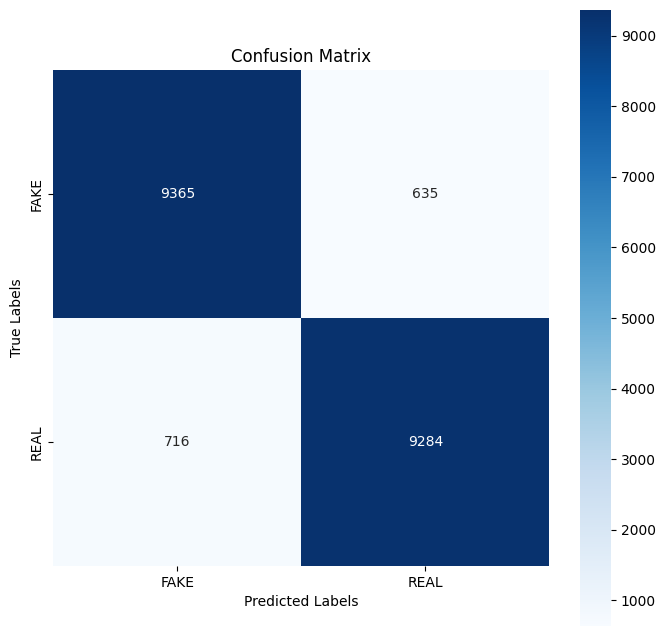

In [185]:
# Confusion matrix
plot_confusion_matrix(test_set_dataloader, model)

[           inf 1.00000000e+00 9.99999881e-01 ... 9.25578461e-18
 9.16164071e-18 6.47077975e-33]
[1.88744540e-04 9.98837769e-01 9.99636531e-01 ... 1.14577473e-03
 9.99848008e-01 1.50480878e-06]


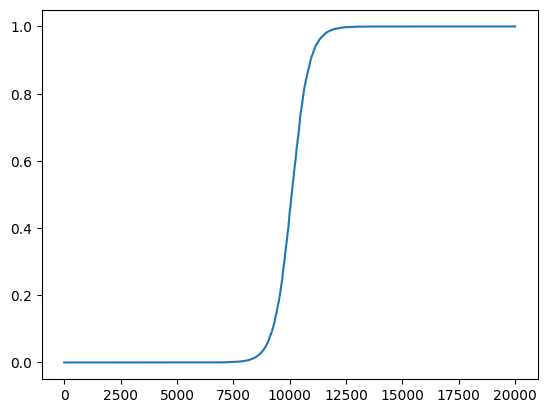

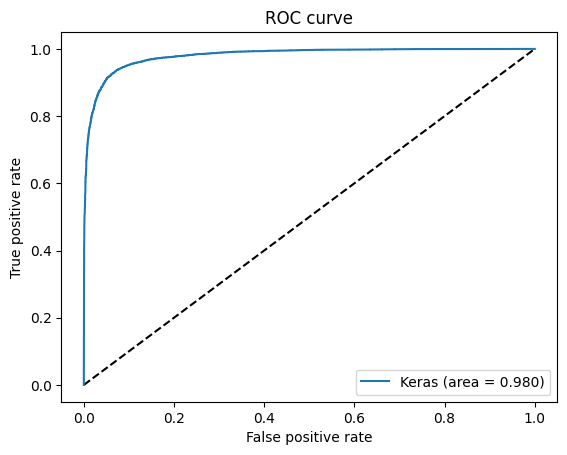

In [210]:
    predicted_values = np.array([])
    predicted_classes = np.array([])
    true_classes = np.array([])
    
    for x, y in test_set_dataloader:
        predicted_values = np.concatenate([predicted_values, model(x)[:,0]])
        predicted_classes = np.concatenate([predicted_classes, [0 if pred < 0.5 else 1 for pred in model(x)]])
        true_classes = np.concatenate([true_classes, np.argmax(y, axis=-1)])


from sklearn.metrics import auc


fpr, tpr, thresholds = roc_curve(true_classes, predicted_values)
roc_auc = auc(fpr, tpr)
print(thresholds)
print(predicted_values)

plt.figure()
plt.plot(np.sort(predicted_values))

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

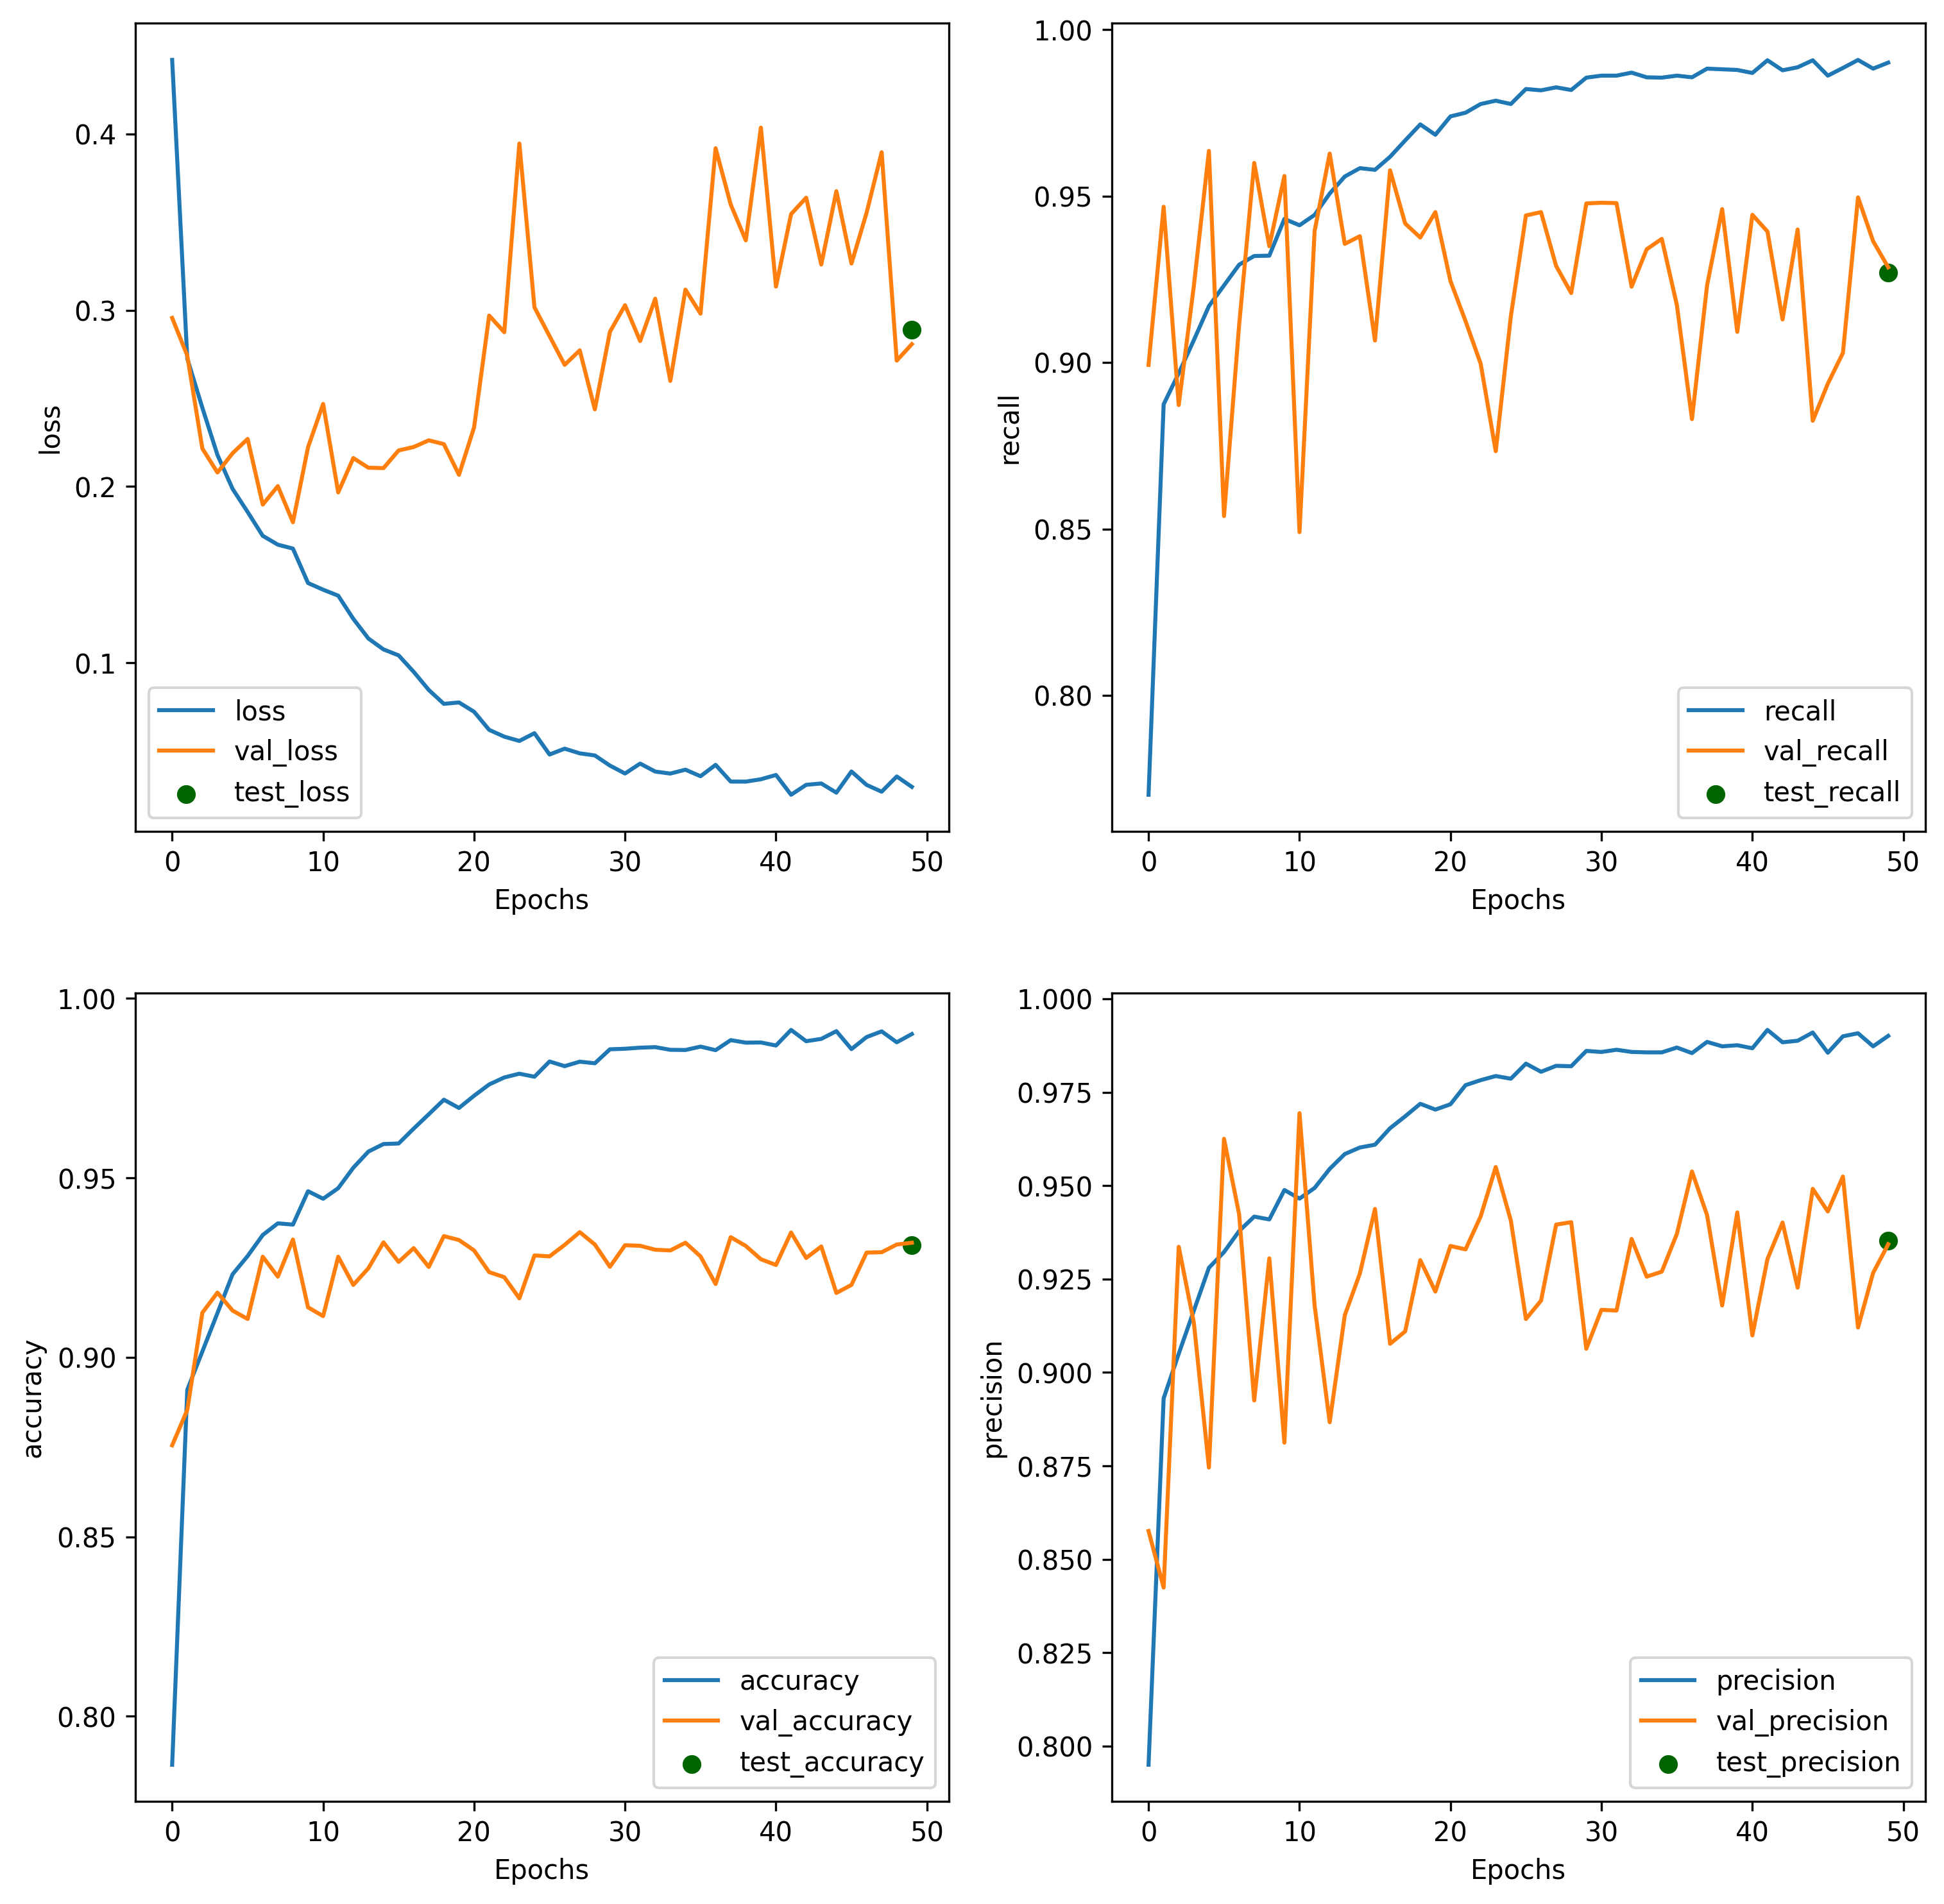

In [100]:
# Display results
plot_metrics(history, test_loss, test_recall, test_accuracy, test_precision, number_of_epochs)

# Constructive criticisms about the current analysis

# Summary of main findings and takeaways to prepare next steps